## 1. Import Libraries and Run Functions 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
def drop_correlated_features(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
    feature_names = [col for col in df.columns if col not in to_drop]
    return feature_names

In [3]:
def convert_to_binary(row):
    if row < 9.5:
        return 0
    elif row >= 9.5:
        return 1
    else:
        return np.nan

## 2. Read the Data

In [144]:
train = pd.read_csv('./training_test_data/train.csv')
train.drop('Unnamed: 0', inplace = True, axis=1)

test = pd.read_csv('./training_test_data/test.csv')
test.drop('Unnamed: 0', inplace = True, axis=1)

In [145]:
y1 = np.array(train['TARGET']).copy()
y2 = train['TARGET'].copy().apply(convert_to_binary)

## 3. Select Features

In [149]:
feature_ranking = pd.read_csv('./feature_selection/feature_ranking.csv')
feature_names_full = list(feature_ranking['feature'].iloc[0:50])
feature_names_full = drop_correlated_features(train[feature_names_full].copy())

In [157]:
lsvc = LinearSVC(C=0.001, penalty="l2", dual=False, max_iter=100).fit(train[feature_names_full].copy(), 
                                                                          train['TARGET'].copy())
model = SelectFromModel(lsvc, prefit=True,max_features=5)
X = model.transform(train[feature_names_full])

In [158]:
mask = model.get_support()
feature_names = []

for bool, feature in zip(mask, feature_names_full):
    if bool:
        feature_names.append(feature)

In [159]:
feature_names

['AWAY_LG_GOALS_H_L2W',
 'HOME_LG_SHOTS_OT_H_L3W',
 'H2H_TOT_CORNERS_HA_L3G',
 'H2H_TOT_SHOTS_HA_L3G',
 'MKT_VAL_RATIO']

## 4. Model

In [161]:
y1_test = np.array(test['TARGET'])
y2_test = np.array(test['TARGET'].apply(convert_to_binary))

In [162]:
rfr = RandomForestClassifier(n_estimators=1800, 
                            criterion='gini', 
                            max_depth=2, 
                            min_samples_split=4,
                            min_samples_leaf=2,
                            random_state=17,
                            verbose=0,
                            warm_start=False,
                            max_features=5)
X = np.array(train[feature_names])
rfr.fit(X,y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [163]:
rfr.feature_importances_

array([0.02487531, 0.08659659, 0.11092456, 0.19273614, 0.5848674 ])

In [164]:
X_test = np.array(test[feature_names])
y2_pred = rfr.predict_proba(X_test)[:,1]
roc_auc_score(y2_test,y2_pred)

0.5178870139398385

In [165]:
y2_pred_train = rfr.predict_proba(X)[:,1]
roc_auc_score(y2,y2_pred_train)

0.608937260660505

In [166]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            pass
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [167]:
def pred_labels(array):
    lst = []
    for i in range(len(array)):
        if array[i] >= 0.575:
            lst.append(1)
        else:
            lst.append(0)
    return lst

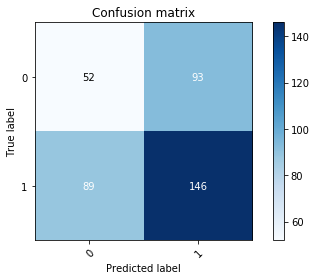

In [168]:
y2_pred_labels = pred_labels(y2_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(y2_test, y2_pred_labels, classes=[0,1],
                      title='Confusion matrix')
plt.show()

In [169]:
cm = confusion_matrix(y2_test, y2_pred_labels)

In [170]:
cm

array([[ 52,  93],
       [ 89, 146]])

In [171]:
accuracy = (cm[1,1] + cm[0,0]) / cm.sum() # Overall, how often is the classifier correct?
precision = cm[1,1] / (cm[0,1] + cm[1,1]) # When it predicts yes, how often is it correct? 
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) # When it's actually yes, how often does it predict yes? 
print('accuracy: {}, precision: {}, sensitivity: {}'.format(round(accuracy,2), round(precision,2), round(sensitivity,2)))

accuracy: 0.52, precision: 0.61, sensitivity: 0.62
